# 기존 polish3 에 trial-pos를 붙임

최종 작업일: 2024-11-02

In [1]:
from matplotlib import font_manager
from matplotlib import rc
import pickle
import re
import pandas as pd

f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()

rc('font', family='Arial Unicode MS')

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from networkx.algorithms import bipartite, community
from networkx.algorithms.community import modularity, louvain_communities
import matplotlib.colors as mcolors
from collections import Counter
import pandas as pd


**주의**

pd.Series.str.replace() 함수를 사용할 때, regex=True 옵션을 주어야 정규식을 사용할 수 있다.

```python

df['title'].str.replace(r'^\d+\.\s*', '', regex=True).str.strip()
```

In [3]:
# 파일 읽기
file_path = '../local_data/annotated_dataset.csv'
df = pd.read_csv(file_path)

# 데이터프레임에서 필요한 열만 추출
df['keywords'] = df['keywords'].apply(lambda x: x.strip("[]").split(", "))
df['keywords'] = df['keywords'].apply(lambda x: [k.strip("'") for k in x])

df['title'] = df['title'].str.replace(r'^\d+\.\s*', '', regex=True).str.strip()

# # 데이터 확인
# print(df.head())


In [4]:
colors = list(mcolors.TABLEAU_COLORS.values())

# 다이나믹스 분석


In [5]:
def create_graph(group):
    '''
    카테고리 - 키워드 Bipartite 그래프 생성
    '''
    B = nx.Graph()
    categories = group['category'].unique()
    keywords = sum(group['keywords'].tolist(), [])
    B.add_nodes_from(categories, bipartite=0)
    B.add_nodes_from(keywords, bipartite=1)
    for _, row in group.iterrows():
        category = row['category']
        for keyword in row['keywords']:
            B.add_edge(category, keyword)
    return B

def calculate_authorities(B):
    '''
    HITS 알고리즘으로 hub와 authority 계산
    
    출력
    - authorities: authority 값
    - sorted_authorities: authority 값으로 정렬된 튜플 리스트
    '''
    hubs, authorities = nx.hits(B)
    sorted_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)
    return authorities, sorted_authorities

def create_projected_graph(category_nodes, B, n):
    '''
    Bipartite 그래프로부터: 카테고리 노드 간의 연결을 기반으로한 Projected 그래프 생성
    
    내용
    - 카테고리 노드 간의 최단 경로 길이가 n 이하인 경우에만 연결
    '''
    projected_graph = nx.Graph()
    projected_graph.add_nodes_from(category_nodes)
    for category in category_nodes:
        lengths = nx.single_source_shortest_path_length(B, category, cutoff=n)
        for target, length in lengths.items():
            if target in category_nodes and category != target:
                if projected_graph.has_edge(category, target):
                    projected_graph[category][target]['weight'] += 1
                else:
                    projected_graph.add_edge(category, target, weight=1)
    return projected_graph

def detect_communities(projected_graph):
    '''
    louvain 알고리즘을 사용하여 커뮤니티 탐지
    '''
    louvain_communities_ = louvain_communities(projected_graph)
    return louvain_communities_

def calculate_community_scores(B, louvain_communities, projected_graph, authorities, keywords):
    '''
    projected_graph: 카테고리간 연결 그래프
    louvain_communities: 이 그래프에서 찾은 커뮤니티
    커뮤니티 내 각 키워드들이 가리키는 키워드의 집합 조회 -> connected_keywords
    
    출력: (중요한 순으로)
    - Nodes: 커뮤니티를 구성하는 카테고리 모음
    - Community: 커뮤니티 번호
    
    '''
    community_scores = []
    for i, comm in enumerate(louvain_communities):
        comm_nodes = list(comm)
        subgraph = projected_graph.subgraph(comm_nodes)
        size = len(comm_nodes)
        density = nx.density(subgraph)
        connected_keywords = set()
        for category in comm_nodes:
            connected_keywords.update(B.neighbors(category))
        keyword_count = len(connected_keywords)
        keyword_ratio = keyword_count / len(keywords)
        community_scores.append({
            'Community': i + 1,
            'Size': size,
            'Density': density,
            'Keyword Count': keyword_count,
            'Keyword Ratio': keyword_ratio,
            'keywords': connected_keywords,
            'Nodes': tuple(sorted(comm_nodes))
        })
    return community_scores

def initial_pass(previous_communities, current_communities):
    '''
    c \in C_{t-1}, c' \in C_{t} 에 대해 
    
    c' == c: c'는 유지 (c: persisting)
    '''
    
    for cur in current_communities.keys():
        for prev in previous_communities.keys():
            if set(cur) == set(prev):
                current_communities[cur]['type'] = ('persisting', prev)
                previous_communities[prev]['type'] = ('persisting', cur)
                break

def first_pass(previous_communities, current_communities):
    '''
    c \in C_{t-1}, c' \in C_{t} 에 대해 
    
    c' 에 대해, c \subset c' 인 c 모두 조사
    - c 가 두가지 이상: c'는 병합 커뮤 (c: to_merge, to_merge, c': merge)
    - c 가 한가지: c'는 확장 커뮤 (c 는 to_expand, c': expand)
    - c 가 없음: c'는 신규 (c': new)
    '''
    
    initial_pass(previous_communities, current_communities)
    
    for cur in current_communities.keys():
        matched_prev = []
        # if 'type' in current_communities[cur] and current_communities[cur]['type'][0] == 'persisting':
        #     continue
        exactly_matched = False
        for prev in previous_communities.keys():
            if set(cur) == set(prev):
                exactly_matched = True
                break
            if set(prev).issubset(set(cur)):
                matched_prev.append(prev)
        if exactly_matched:
            continue
        if len(matched_prev) == 0:
            current_communities[cur]['type'] = ('new', None)
        elif len(matched_prev) == 1:
            current_communities[cur]['type'] = ('expand_from', matched_prev)
            for m in matched_prev:
                previous_communities[m]['type'] = ('expand_to', cur)
        else:
            current_communities[cur]['type'] = ('merge_from', matched_prev)
            for m in matched_prev:
                previous_communities[m]['type'] = ('merge_to', cur)
            
def second_pass(previous_communities, current_communities):
    '''
    c \in C_{t-1}, c' \in C_{t} 에 대해 
    
    c 에 대해, c' \subset c 인 c' 모두 조사
    - c' 가 두가지 이상: c'는 분리 (c: to_split, c': split, spllit)
    - c' 가 한가지: c'는 축소 (c: to_shrink, c': shrink)
    - c' 가 없음: c'는 소멸 (c: to_disapper)
    '''
    
    for prev in previous_communities.keys():
        matched_curr = []
        # if 'type' in previous_communities[prev] and previous_communities[prev]['type'][0] == 'persisting':
        #     continue
        exactly_matched = False
        for cur in current_communities.keys():
            if set(cur) == set(prev):
                exactly_matched = True
                break
            if set(cur).issubset(set(prev)):
                matched_curr.append(cur)
        if exactly_matched:
            continue
        
        if len(matched_curr) == 0:
            # first_pass 에서 확장으로 결론 냈는데, 이를 다시 disappear로 바꾸는 것 방지
            if 'type' in previous_communities[prev] and previous_communities[prev]['type'][0] in ['expand_to', 'merge_to']:
                continue
            previous_communities[prev]['type'] = ('disappear', None)
        elif len(matched_curr) == 1:
            previous_communities[prev]['type'] = ('shrink_to', matched_curr)
            for m in matched_curr:
                current_communities[m]['type'] = ('shrink_from', prev)
        else:
            previous_communities[prev]['type'] = ('split_to', matched_curr)
            for m in matched_curr:
                current_communities[m]['type'] = ('split_from', prev)


def analyze_community_dynamics(previous_communities, current_communities, authorities, trial_index):
    '''
    커뮤니티 다이나믹스 분석
    
    입력
    - previous_communities: 이전 트라이얼의 커뮤니티
    - current_communities: 현재 트라이얼의 커뮤니티
    '''
    
    # initial_pass(previous_communities, current_communities)
    first_pass(previous_communities, current_communities)
    second_pass(previous_communities, current_communities)
    
    print(f"Trial {trial_index}:")
    
    # 분석 0: P: persisting
    set_P = set()
    for cur in current_communities.keys():
        if current_communities[cur]['type'][0] == 'persisting':
            print(f"P {cur}")
            set_P.add(cur)
    
    # 분석 1: N: new
    set_N = set()
    for cur in current_communities.keys():
        if current_communities[cur]['type'][0] == 'new':
            set_N.add(cur)
            print(f"N {cur}")
            
    # 분석 2: D: disappear
    set_D = set()
    for prev in previous_communities.keys():
        if previous_communities[prev]['type'][0] == 'disappear':
            set_D.add(prev)
            print(f"D {prev}")
            
    # 분석 3: E: expand, M: merge, SH: shrink, SP: split
    set_E, set_E_from = set(), set()
    set_M, set_M_from = set(), set()
    set_SH, set_SH_from = set(), set()
    set_SP, set_SP_from = set(), set()
    for cur in current_communities.keys():
        if current_communities[cur]['type'][0] == 'expand_from':
            prev = current_communities[cur]['type'][1]
            set_E.add(cur)
            set_E_from |= set(prev) # 튜플의 리스트이므로, set으로 변환
            print(f"E {cur} from {prev}")
        elif current_communities[cur]['type'][0] == 'merge_from':
            prev = current_communities[cur]['type'][1]
            set_M.add(cur)
            set_M_from |= set(prev) # 튜플의 리스트이므로, set으로 변환
            print(f"M {cur} from {prev}")
        elif current_communities[cur]['type'][0] == 'shrink_from':
            prev = current_communities[cur]['type'][1]
            set_SH.add(cur)
            set_SH_from.add(prev)
            print(f"SH {cur} from {prev}")
        elif current_communities[cur]['type'][0] == 'split_from':
            prev = current_communities[cur]['type'][1]
            set_SP.add(cur)
            set_SP_from.add(prev)
            print(f"SP {cur} from {prev}")
            
    print("***************")
    

    return (
        set_N, # 신규
        set_D, # 삭제
        set_P, # 유지
        set_E, set_E_from, # 확장
        set_M, set_M_from, # 병합
        set_SH, set_SH_from, # 축소
        set_SP, set_SP_from, # 분리
    )

def visualize_community_counts(community_counts, tester):
    trial_indices, counts = zip(*community_counts)
    plt.figure(figsize=(6, 3))
    plt.plot(trial_indices, counts, marker='o')
    plt.xlabel('Trial Index')
    plt.ylabel('Number of Communities')
    plt.title(f'Number of Communities Over Time: {tester}')
    plt.show()

def visualize_community_sizes(community_sizes, tester):
    plt.figure(figsize=(6, 3))
    for trial_index, sizes in community_sizes:
        plt.scatter([trial_index] * len(sizes), sizes)
    plt.xlabel('Trial Index')
    plt.ylabel('Community Size (Keyword Count)')
    plt.title(f'Community Size (Keyword Count) Over Time: {tester}')
    plt.show()

def visualize_community_persistence(community_persistence, tester):
    persisting_counts = [entry['persisting'] for entry in community_persistence]
    new_counts = [entry['new'] for entry in community_persistence]
    disappearing_counts = [entry['disappearing'] for entry in community_persistence]
    shrinking_counts = [entry['shrinking'] for entry in community_persistence]
    expanding_counts = [entry['expanding'] for entry in community_persistence]
    persisting_trial_indices = [entry['trial_idx'] for entry in community_persistence]
    plt.figure(figsize=(6, 3))
    plt.plot(persisting_trial_indices, persisting_counts, marker='o', label='Persisting')
    plt.plot(persisting_trial_indices, new_counts, marker='o', label='New')
    plt.plot(persisting_trial_indices, disappearing_counts, marker='o', label='Disappearing')
    plt.plot(persisting_trial_indices, shrinking_counts, marker='o', label='Shrinking')
    plt.plot(persisting_trial_indices, expanding_counts, marker='o', label='Expanding')
    plt.xlabel('Trial Index')
    plt.ylabel('Number of Communities')
    plt.title(f'Community Persistence Over Time: {tester}')
    plt.legend()
    plt.show()

def visualize_community_movement(community_movement, tester):
    movement_df = pd.DataFrame(community_movement)
    if not movement_df.empty:
        movement_df['color'] = movement_df['community'].apply(lambda x: colors[x % len(colors)])
        plt.figure(figsize=(6, 3))
        for community, group in movement_df.groupby('community'):
            plt.plot(group['trial_idx'], group['prev_center'], marker='o', linestyle='-', label=f'Community {community} Prev', color=group['color'].iloc[0])
            plt.plot(group['trial_idx'], group['curr_center'], marker='x', linestyle='--', label=f'Community {community} Curr', color=group['color'].iloc[0])
        plt.xlabel('Trial Index')
        plt.ylabel('Center Node')
        plt.title(f'Community Center Movement Over Time: {tester}')
        plt.legend()
        plt.show()

def print_category_stats(counter, title, max_len=5):
    sorted_categories = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    print(f"\n{title}:")
    for i, (categories, count) in enumerate(sorted_categories):
        print(f"{categories}: {count}")
        if max_len > 0 and i == max_len - 1:
            break



In [6]:
def analyze_loop(df, tester):
    filtered_df = df[df['tester'] == tester]
    grouped = filtered_df.groupby('trial_idx')
    graphs = []
    community_dynamics = []
    n = 8
    previous_communities = {}
    community_counts = []
    community_sizes = []
    community_persistence = []
    community_movement = []
    persisting_communities_counter = Counter()
    disappearing_communities_counter = Counter()
    new_communities_counter = Counter()
    shrinking_communities_counter = Counter()
    shrinking_communities_from_counter = Counter()
    expanding_communities_counter = Counter()
    expanding_communities_from_counter = Counter()
    merging_communities_counter = Counter()
    merging_communities_from_counter = Counter()
    split_communities_counter = Counter()
    split_communities_from_counter = Counter()

    for trial_index, group in grouped:
        B = create_graph(group)
        graphs.append((trial_index, B))
        authorities, sorted_authorities = calculate_authorities(B)
        category_nodes = set(group['category'].unique())
        projected_graph = create_projected_graph(category_nodes, B, n)
        louvain_communities_ = detect_communities(projected_graph)
        community_scores = calculate_community_scores(B, louvain_communities_, projected_graph, authorities, sum(group['keywords'].tolist(), []))
        for comm in community_scores:
            comm['prev_comm'] = None
            comm['next_comm'] = None
        current_communities = {comm['Nodes']: comm for comm in community_scores}
        if previous_communities:
            (
                new_communities,
                disappearing_communities,
                persisting_communities,
                expanding_communities, expanding_communities_from,
                merging_communities, merging_communities_from,
                shrinking_communities, shrinking_communities_from,
                split_communities, split_communities_from,
                
            ) = analyze_community_dynamics(
                previous_communities, current_communities, authorities, trial_index
            )

            community_persistence.append({
                "trial_idx": trial_index,
                "new": len(new_communities),
                "disappearing": len(disappearing_communities),
                "persisting": len(persisting_communities),
                "shrinking": len(shrinking_communities),
                "expanding": len(expanding_communities),
                "merging": len(merging_communities),
                "split": len(split_communities),
                "history": {"new": new_communities, 
                            "disappearing": disappearing_communities, 
                            "persisting": persisting_communities, 
                            "shrinking": shrinking_communities,
                            "shrinking_from": shrinking_communities_from,
                            "expanding": expanding_communities, 
                            "expanding_from": expanding_communities_from,
                            "merging": merging_communities, 
                            "merging_from": merging_communities_from,
                            "split": split_communities, 
                            "split_from": split_communities_from,
                            # merge_split_info": from_to_persistent_communities
                            }
            })
            persisting_communities_counter.update(persisting_communities)
            new_communities_counter.update(new_communities)
            disappearing_communities_counter.update(disappearing_communities)
            shrinking_communities_counter.update(shrinking_communities)
            shrinking_communities_from_counter.update(shrinking_communities_from)
            expanding_communities_counter.update(expanding_communities)
            expanding_communities_from_counter.update(expanding_communities_from)
            merging_communities_counter.update(merging_communities)
            merging_communities_from_counter.update(merging_communities_from)
            split_communities_counter.update(split_communities)
            split_communities_from_counter.update(split_communities_from)
            
            # for comm_nodes in persisting_communities:
            #     prev_comm = previous_communities[comm_nodes]
            #     curr_comm = current_communities[comm_nodes]
            #     prev_center = max(prev_comm['Nodes'], key=lambda node: authorities[node])
            #     curr_center = max(curr_comm['Nodes'], key=lambda node: authorities[node])
            #     community_movement.append({
            #         'trial_idx': trial_index,
            #         'community': curr_comm['Community'],
            #         'prev_center': prev_center,
            #         'curr_center': curr_center
            #     })
        previous_communities = current_communities
        sorted_communities = sorted(community_scores, key=lambda x: (x['Keyword Count'], x['Density']), reverse=True)
        for comm in sorted_communities:
            # print(f"Community {comm['Community']}: Size={comm['Size']}, Density={comm['Density']:.4f}, Keyword Count={comm['Keyword Count']}, Keyword Ratio={comm['Keyword Ratio']:.4f}")
            # print(f"Nodes: {', '.join(comm['Nodes'])}")
            comm_authorities = [(node, authorities[node]) for node in comm['Nodes']]
            comm_authorities_sorted = sorted(comm_authorities, key=lambda x: x[1], reverse=True)
            # for rank, (node, score) in enumerate(comm_authorities_sorted, start=1):
            #     print(f"  {node}: Authority={score:.4f}, Rank={rank}")
        community_counts.append((trial_index, len(louvain_communities_)))
        community_sizes.append((trial_index, [comm['Keyword Count'] for comm in sorted_communities]))

    # visualize_community_counts(community_counts, tester)
    # visualize_community_sizes(community_sizes, tester)
    visualize_community_persistence(community_persistence, tester)
    # visualize_community_movement(community_movement, tester)
    print_category_stats(persisting_communities_counter, "Persisting Communities")
    print_category_stats(disappearing_communities_counter, "Disappearing Communities")
    print_category_stats(new_communities_counter, "New Communities")
    print_category_stats(shrinking_communities_counter, "Shrinking Communities")
    print_category_stats(shrinking_communities_from_counter, "Shrinking Communities From")
    print_category_stats(expanding_communities_counter, "Expanding Communities")
    print_category_stats(expanding_communities_from_counter, "Expanding Communities From")
    print_category_stats(merging_communities_counter, "Merged Communities")
    print_category_stats(merging_communities_from_counter, "Merged Communities From")
    print_category_stats(split_communities_counter, "Split Communities")
    print_category_stats(split_communities_from_counter, "Split Communities From")
    
    return community_persistence

========== START: Analyzing 김미령 ==========
Trial 1:
P ('4.3. 패션/뷰티',)
P ('4.2. 요리/맛집',)
N ('4.10. 취미/DIY',)
N ('1.1.2. 국회/입법부',)
N ('2.6. 경제 정책',)
N ('8.4. 해외 축구',)
N ('1.4.2. 무기/방위산업',)
N ('6.4. 중동/아프리카',)
N ('7.6. 셀러브리티/인플루언서',)
N ('4.5. 자동차',)
N ('1.1.3. 지방자치', '2.4. 산업/기업', '4.9. 반려동물')
N ('1.1.1. 청와대/행정부',)
N ('3.2. 교육',)
N ('2.3. 부동산',)
N ('6.1. 아시아/호주',)
N ('3.1. 사건사고',)
N ('4.1. 건강', '5.5. 과학 일반')
N ('7.3. 음악',)
N ('8.9. 테니스',)
N ('3.4. 환경',)
N ('9.2. 칼럼',)
N ('(제목이 불충분하여 카테고리 할당 불가)',)
N ('7.2. 방송/드라마', '7.4. 스타/연예인')
N ('4.11. 웨딩/결혼',)
D ('2.5. 중소기업/창업',)
D ('13.3. 학자/전문가', '4.9. 반려동물')
***************
Trial 2:
P ('2.6. 경제 정책',)
P ('4.5. 자동차',)
P ('3.2. 교육',)
P ('3.1. 사건사고',)
P ('4.3. 패션/뷰티',)
P ('3.4. 환경',)
P ('4.2. 요리/맛집',)
N ('3.5. 인권/복지',)
N ('4.4. 여행/레저',)
N ('5.3. 통신/뉴미디어',)
N ('2.5. 중소기업/창업',)
N ('5.2. 인터넷/SNS',)
N ('7.1. 영화',)
N ('2.4.1. 글로벌 기업 동향', '8.3. 국내 축구')
N ('5.4. IT 기기',)
N ('4.8. 육아/교육',)
D ('4.10. 취미/DIY',)
D ('1.1.2. 국회/입법부',)
D ('8.4. 해외 축구',)
D ('6.4. 중동

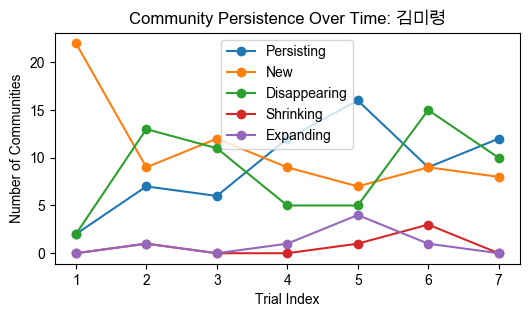


Persisting Communities:
('4.2. 요리/맛집',): 7
('4.3. 패션/뷰티',): 6
('7.4. 스타/연예인',): 5
('3.1. 사건사고',): 4
('4.8. 육아/교육',): 3

Disappearing Communities:
('2.5. 중소기업/창업',): 2
('7.6. 셀러브리티/인플루언서',): 2
('8.4. 해외 축구',): 2
('1.1.2. 국회/입법부',): 2
('4.11. 웨딩/결혼',): 2

New Communities:
('1.1.2. 국회/입법부',): 3
('4.11. 웨딩/결혼',): 3
('5.4. IT 기기',): 3
('5.2. 인터넷/SNS',): 3
('7.6. 셀러브리티/인플루언서',): 2

Shrinking Communities:
('4.1. 건강',): 1
('2.1.1. 글로벌 금융시장',): 1
('8.4. 해외 축구',): 1
('2.6. 경제 정책',): 1
('4.9. 반려동물',): 1

Shrinking Communities From:
('4.1. 건강', '5.5. 과학 일반'): 1
('2.1.1. 글로벌 금융시장', '2.4.1. 글로벌 기업 동향'): 1
('2.6. 경제 정책', '2.6.1. 국제 경제 정책', '4.1. 건강'): 1
('4.9. 반려동물', '7.1. 영화'): 1
('6.1. 아시아/호주', '8.4. 해외 축구'): 1

Expanding Communities:
('1.2.1. 외교/국제관계', '1.4.2. 무기/방위산업'): 1
('2.1.1. 글로벌 금융시장', '2.4.1. 글로벌 기업 동향'): 1
('2.6. 경제 정책', '2.6.1. 국제 경제 정책', '4.1. 건강'): 1
('1.1.3. 지방자치', '3.3. 노동'): 1
('2.4. 산업/기업', '2.4.1. 글로벌 기업 동향', '7.3. 음악'): 1

Expanding Communities From:
('1.4.2. 무기/방위산업',): 1
('2.1

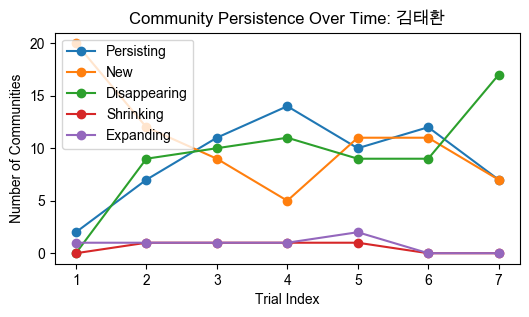


Persisting Communities:
('8.5. 골프',): 5
('4.2. 요리/맛집',): 5
('1.1.1. 청와대/행정부',): 5
('4.5. 자동차',): 4
('4.1. 건강',): 4

Disappearing Communities:
('1.2.1. 외교/국제관계',): 2
('8.10. 격투기 (복싱, UFC 등)',): 2
('3.1.1. 국제 사건사고',): 2
('5.6. 우주/항공',): 2
('8.6. 농구',): 2

New Communities:
('7.3. 음악',): 3
('1.2.1. 외교/국제관계',): 2
('3.2. 교육',): 2
('8.1. 국내 야구',): 2
('3.5. 인권/복지',): 2

Shrinking Communities:
('2.4. 산업/기업',): 1
('3.1. 사건사고',): 1
('2.1.1. 글로벌 금융시장',): 1
('4.11. 웨딩/결혼',): 1

Shrinking Communities From:
('2.4. 산업/기업', '4.4. 여행/레저', '7.4. 스타/연예인'): 1
('3.1. 사건사고', '7.4. 스타/연예인'): 1
('2.1.1. 글로벌 금융시장', '7.2. 방송/드라마', '7.4. 스타/연예인'): 1
('3.1. 사건사고', '4.11. 웨딩/결혼', '7.2. 방송/드라마', '7.4. 스타/연예인'): 1

Expanding Communities:
('2.3. 부동산', '8.4. 해외 축구'): 1
('3.1. 사건사고', '7.4. 스타/연예인'): 1
('2.1.1. 글로벌 금융시장', '7.2. 방송/드라마', '7.4. 스타/연예인'): 1
('3.1. 사건사고', '4.11. 웨딩/결혼', '7.2. 방송/드라마', '7.4. 스타/연예인'): 1
('13.3. 학자/전문가', '3.1. 사건사고', '7.1. 영화'): 1

Expanding Communities From:
('3.1. 사건사고',): 2
('8.4. 해외 축구',)

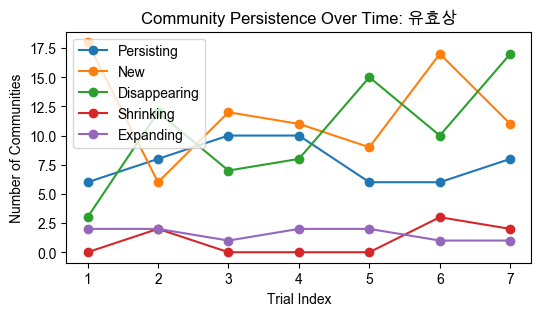


Persisting Communities:
('4.1. 건강',): 7
('3.2. 교육',): 5
('4.4. 여행/레저',): 4
('3.1. 사건사고',): 4
('8.2. 해외 야구',): 3

Disappearing Communities:
('11.1. 수도권',): 3
('4.10. 취미/DIY',): 2
('7.2. 방송/드라마',): 2
('1.1.2. 국회/입법부',): 2
('4.11. 웨딩/결혼',): 2

New Communities:
('7.2. 방송/드라마',): 3
('8.1. 국내 야구',): 3
('5.2. 인터넷/SNS',): 3
('2.1. 금융',): 3
('4.5. 자동차',): 2

Shrinking Communities:
('2.3. 부동산',): 1
('2.4.1. 글로벌 기업 동향',): 1
('3.3. 노동',): 1
('3.1. 사건사고',): 1
('8.4. 해외 축구',): 1

Shrinking Communities From:
('2.4.1. 글로벌 기업 동향', '3.5. 인권/복지'): 1
('2.3. 부동산', '6.4. 중동/아프리카'): 1
('5.5. 과학 일반', '8.4. 해외 축구'): 1
('2.4. 산업/기업', '3.1. 사건사고'): 1
('3.3. 노동', '3.5. 인권/복지'): 1

Expanding Communities:
('2.4.1. 글로벌 기업 동향', '3.5. 인권/복지'): 1
('2.3. 부동산', '6.4. 중동/아프리카'): 1
('2.6.1. 국제 경제 정책', '5.5. 과학 일반', '8.3. 국내 축구'): 1
('3.3. 노동', '3.4. 환경', '3.5. 인권/복지'): 1
('2.4. 산업/기업', '2.6. 경제 정책'): 1

Expanding Communities From:
('2.3. 부동산',): 2
('2.4.1. 글로벌 기업 동향',): 1
('5.5. 과학 일반',): 1
('3.3. 노동',): 1
('2.4. 산업/기업',)

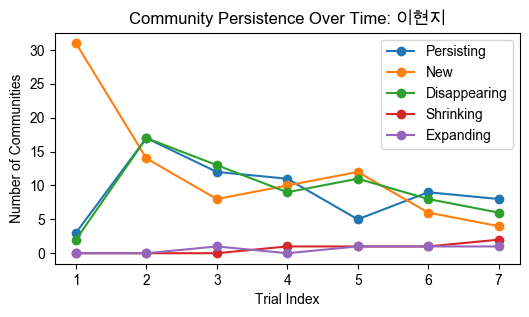


Persisting Communities:
('3.1. 사건사고',): 6
('4.1. 건강',): 5
('4.6. 책/문학',): 4
('3.2. 교육',): 4
('4.3. 패션/뷰티',): 4

Disappearing Communities:
('8.4. 해외 축구',): 3
('12.2. 전시/공연',): 2
('1.1.1. 청와대/행정부',): 2
('2.1. 금융',): 2
('5.1. 모바일',): 2

New Communities:
('8.3. 국내 축구',): 3
('1.1.2. 국회/입법부',): 3
('1.1.1. 청와대/행정부',): 3
('5.1. 모바일',): 3
('8.4. 해외 축구',): 3

Shrinking Communities:
('7.2. 방송/드라마',): 1
('4.9. 반려동물',): 1
('7.2. 방송/드라마', '7.4. 스타/연예인'): 1
('7.4. 스타/연예인',): 1
('8.1. 국내 야구',): 1

Shrinking Communities From:
('1.1.3. 지방자치', '4.9. 반려동물', '7.2. 방송/드라마'): 1
('2.6.1. 국제 경제 정책', '4.9. 반려동물'): 1
('4.6. 책/문학', '7.2. 방송/드라마', '7.4. 스타/연예인'): 1
('5.4. IT 기기', '8.1. 국내 야구'): 1
('7.2. 방송/드라마', '7.4. 스타/연예인'): 1

Expanding Communities:
('2.4.1. 글로벌 기업 동향', '6.1. 아시아/호주'): 1
('2.4. 산업/기업', '4.2. 요리/맛집'): 1
('2.4.1. 글로벌 기업 동향', '5.3. 통신/뉴미디어'): 1
('4.1. 건강', '4.9. 반려동물'): 1

Expanding Communities From:
('2.4.1. 글로벌 기업 동향',): 2
('4.2. 요리/맛집',): 1
('4.1. 건강',): 1

Merged Communities:
('2.4. 산업/기업', 

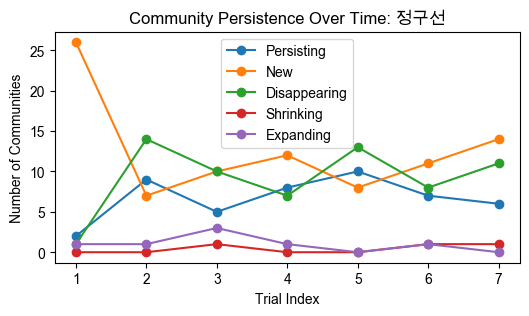


Persisting Communities:
('4.4. 여행/레저',): 6
('5.8. 블록체인/가상화폐',): 6
('8.2. 해외 야구',): 5
('3.1. 사건사고',): 4
('8.5. 골프',): 4

Disappearing Communities:
('2.1. 금융',): 3
('11.1. 수도권',): 3
('1.1.2. 국회/입법부',): 3
('8.3. 국내 축구',): 2
('8.4. 해외 축구',): 2

New Communities:
('8.3. 국내 축구',): 3
('4.1. 건강',): 3
('2.1. 금융',): 3
('7.3. 음악',): 3
('4.2. 요리/맛집',): 3

Shrinking Communities:
('3.3. 노동',): 1
('4.5. 자동차',): 1
('8.1. 국내 야구',): 1

Shrinking Communities From:
('2.6. 경제 정책', '3.3. 노동'): 1
('2.4. 산업/기업', '4.5. 자동차'): 1
('5.4. IT 기기', '8.1. 국내 야구'): 1

Expanding Communities:
('2.4. 산업/기업', '4.5. 자동차'): 1
('2.3. 부동산', '3.4. 환경'): 1
('3.1. 사건사고', '7.4. 스타/연예인'): 1
('14.1. 한국사', '4.10. 취미/DIY'): 1
('2.3. 부동산', '2.6. 경제 정책', '3.5. 인권/복지'): 1

Expanding Communities From:
('4.5. 자동차',): 1
('2.3. 부동산',): 1
('3.5. 인권/복지',): 1
('4.10. 취미/DIY',): 1
('3.1. 사건사고',): 1

Merged Communities:
('2.4. 산업/기업', '2.4.1. 글로벌 기업 동향', '4.5. 자동차', '5.1. 모바일', '5.4. IT 기기', '7.4. 스타/연예인'): 1
('2.6. 경제 정책', '3.3. 노동'): 1
('3.5. 

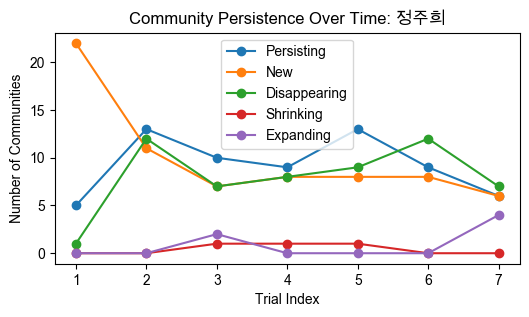


Persisting Communities:
('2.3. 부동산',): 6
('4.3. 패션/뷰티',): 6
('4.1. 건강',): 6
('4.4. 여행/레저',): 4
('1.1.1. 청와대/행정부',): 4

Disappearing Communities:
('11.3. 전라/경상',): 2
('3.2. 교육',): 2
('4.5. 자동차',): 2
('4.11. 웨딩/결혼',): 2
('3.1.1. 국제 사건사고',): 2

New Communities:
('4.5. 자동차',): 3
('2.1. 금융',): 3
('11.3. 전라/경상',): 2
('3.2. 교육',): 2
('12.2. 전시/공연',): 2

Shrinking Communities:
('7.2. 방송/드라마',): 1
('4.10. 취미/DIY',): 1
('4.4. 여행/레저',): 1

Shrinking Communities From:
('7.2. 방송/드라마', '7.4. 스타/연예인'): 1
('2.1. 글로벌 금융시장', '4.10. 취미/DIY'): 1
('3.4. 환경', '4.4. 여행/레저'): 1

Expanding Communities:
('4.8. 육아/교육', '7.4. 스타/연예인'): 1
('2.1. 글로벌 금융시장', '4.10. 취미/DIY'): 1
('2.2. 증권/주식', '2.4. 산업/기업'): 1
('4.6. 책/문학', '4.8. 육아/교육'): 1
('3.1. 사건사고', '7.2. 방송/드라마', '7.3. 음악', '7.4. 스타/연예인'): 1

Expanding Communities From:
('4.8. 육아/교육',): 2
('4.10. 취미/DIY',): 1
('2.1. 금융',): 1
('7.3. 음악',): 1
('2.2. 증권/주식',): 1

Merged Communities:
('7.2. 방송/드라마', '7.4. 스타/연예인'): 1
('2.2. 증권/주식', '2.4. 산업/기업', '2.4.1. 글로벌 기업 동향',

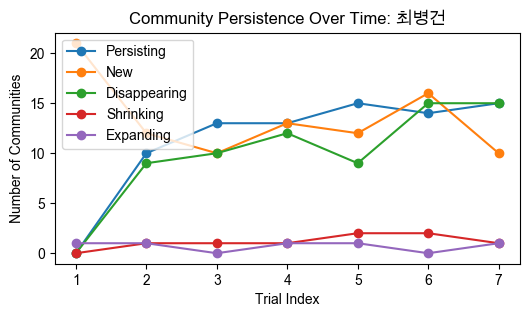


Persisting Communities:
('2.3. 부동산',): 6
('4.1. 건강',): 6
('7.2. 방송/드라마',): 5
('5.8. 블록체인/가상화폐',): 4
('7.1. 영화',): 4

Disappearing Communities:
('4.4. 여행/레저',): 3
('1.4.3. 사이버 안보',): 2
('6.6. 세계 일반',): 2
('8.8. e스포츠',): 2
('8.1. 국내 야구',): 2

New Communities:
('4.4. 여행/레저',): 3
('8.3. 국내 축구',): 2
('7.4. 스타/연예인',): 2
('2.1. 금융',): 2
('1.4.3. 사이버 안보',): 2

Shrinking Communities:
('5.5. 과학 일반',): 1
('5.2. 인터넷/SNS',): 1
('2.4. 산업/기업',): 1
('4.5. 자동차',): 1
('2.6. 경제 정책',): 1

Shrinking Communities From:
('2.4. 산업/기업', '3.1. 사건사고', '3.3. 노동', '5.5. 과학 일반', '6.1. 아시아/호주'): 1
('5.2. 인터넷/SNS', '5.4. IT 기기'): 1
('2.4. 산업/기업', '4.5. 자동차'): 1
('2.1.1. 글로벌 금융시장', '4.5. 자동차', '5.7. 인공지능'): 1
('2.6. 경제 정책', '7.5. 애니메이션/웹툰'): 1

Expanding Communities:
('1.2.1. 외교/국제관계', '2.4.1. 글로벌 기업 동향', '4.6. 책/문학', '5.2. 인터넷/SNS', '5.4. IT 기기', '7.5. 애니메이션/웹툰'): 1
('2.4. 산업/기업', '2.4.1. 글로벌 기업 동향', '3.3. 노동', '4.5. 자동차'): 1
('2.1.1. 글로벌 금융시장', '4.5. 자동차', '5.7. 인공지능'): 1
('13.3. 학자/전문가', '8.4. 해외 축구'): 1
('1.4.3. 사

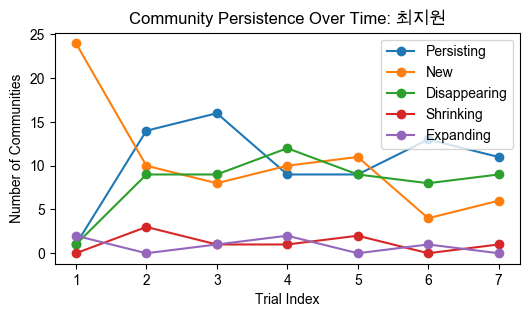


Persisting Communities:
('4.4. 여행/레저',): 6
('2.3. 부동산',): 6
('4.2. 요리/맛집',): 6
('4.1. 건강',): 6
('4.5. 자동차',): 4

Disappearing Communities:
('5.6. 우주/항공',): 3
('5.4. IT 기기',): 2
('13.3. 학자/전문가',): 2
('8.10. 격투기 (복싱, UFC 등)',): 2
('11.1. 수도권',): 2

New Communities:
('2.6. 경제 정책',): 3
('8.4. 해외 축구',): 3
('5.6. 우주/항공',): 3
('1.2.1. 외교/국제관계',): 2
('4.5. 자동차',): 2

Shrinking Communities:
('8.1. 국내 야구',): 2
('7.4. 스타/연예인',): 1
('3.1.1. 국제 사건사고',): 1
('3.1. 사건사고',): 1
('2.4. 산업/기업',): 1

Shrinking Communities From:
('2.4. 산업/기업', '8.1. 국내 야구'): 1
('3.1. 사건사고', '3.1.1. 국제 사건사고'): 1
('7.4. 스타/연예인', '7.6. 셀러브리티/인플루언서'): 1
('2.4. 산업/기업', '3.1. 사건사고', '5.2. 인터넷/SNS'): 1
('2.4. 산업/기업', '2.4.1. 글로벌 기업 동향'): 1

Expanding Communities:
('4.3. 패션/뷰티', '7.2. 방송/드라마'): 1
('7.4. 스타/연예인', '7.6. 셀러브리티/인플루언서'): 1
('2.4. 산업/기업', '2.4.1. 글로벌 기업 동향'): 1
('2.4.1. 글로벌 기업 동향', '6.2. 미국/중남미', '8.1. 국내 야구'): 1
('3.4. 환경', '4.9. 반려동물'): 1

Expanding Communities From:
('7.4. 스타/연예인',): 1
('4.3. 패션/뷰티',): 1
('2.4.1. 글로벌

In [7]:
unique_testers = df['tester'].unique()
analysis_results = []
for tester in unique_testers:
    print(f"========== START: Analyzing {tester} ==========")
    analysis_results.append({"tester":tester, "result":analyze_loop(df, tester)})
    print(f"========== END: Analyzing {tester} ==========")
    # break


In [8]:
analysis_results

[{'tester': '김미령',
  'result': [{'trial_idx': 1,
    'new': 22,
    'disappearing': 2,
    'persisting': 2,
    'shrinking': 0,
    'expanding': 0,
    'merging': 0,
    'split': 0,
    'history': {'new': {('(제목이 불충분하여 카테고리 할당 불가)',),
      ('1.1.1. 청와대/행정부',),
      ('1.1.2. 국회/입법부',),
      ('1.1.3. 지방자치', '2.4. 산업/기업', '4.9. 반려동물'),
      ('1.4.2. 무기/방위산업',),
      ('2.3. 부동산',),
      ('2.6. 경제 정책',),
      ('3.1. 사건사고',),
      ('3.2. 교육',),
      ('3.4. 환경',),
      ('4.1. 건강', '5.5. 과학 일반'),
      ('4.10. 취미/DIY',),
      ('4.11. 웨딩/결혼',),
      ('4.5. 자동차',),
      ('6.1. 아시아/호주',),
      ('6.4. 중동/아프리카',),
      ('7.2. 방송/드라마', '7.4. 스타/연예인'),
      ('7.3. 음악',),
      ('7.6. 셀러브리티/인플루언서',),
      ('8.4. 해외 축구',),
      ('8.9. 테니스',),
      ('9.2. 칼럼',)},
     'disappearing': {('13.3. 학자/전문가', '4.9. 반려동물'), ('2.5. 중소기업/창업',)},
     'persisting': {('4.2. 요리/맛집',), ('4.3. 패션/뷰티',)},
     'shrinking': set(),
     'shrinking_from': set(),
     'expanding': set(),
     'expanding_f

In [9]:
analysis_results[0]['result'][1]['history']

{'new': {('2.4.1. 글로벌 기업 동향', '8.3. 국내 축구'),
  ('2.5. 중소기업/창업',),
  ('3.5. 인권/복지',),
  ('4.4. 여행/레저',),
  ('4.8. 육아/교육',),
  ('5.2. 인터넷/SNS',),
  ('5.3. 통신/뉴미디어',),
  ('5.4. IT 기기',),
  ('7.1. 영화',)},
 'disappearing': {('(제목이 불충분하여 카테고리 할당 불가)',),
  ('1.1.1. 청와대/행정부',),
  ('1.1.2. 국회/입법부',),
  ('2.3. 부동산',),
  ('4.10. 취미/DIY',),
  ('4.11. 웨딩/결혼',),
  ('6.1. 아시아/호주',),
  ('6.4. 중동/아프리카',),
  ('7.3. 음악',),
  ('7.6. 셀러브리티/인플루언서',),
  ('8.4. 해외 축구',),
  ('8.9. 테니스',),
  ('9.2. 칼럼',)},
 'persisting': {('2.6. 경제 정책',),
  ('3.1. 사건사고',),
  ('3.2. 교육',),
  ('3.4. 환경',),
  ('4.2. 요리/맛집',),
  ('4.3. 패션/뷰티',),
  ('4.5. 자동차',)},
 'shrinking': {('4.1. 건강',)},
 'shrinking_from': {('4.1. 건강', '5.5. 과학 일반')},
 'expanding': {('1.2.1. 외교/국제관계', '1.4.2. 무기/방위산업')},
 'expanding_from': {('1.4.2. 무기/방위산업',)},
 'merging': set(),
 'merging_from': set(),
 'split': {('2.4. 산업/기업',),
  ('4.9. 반려동물',),
  ('7.2. 방송/드라마',),
  ('7.4. 스타/연예인',)},
 'split_from': {('1.1.3. 지방자치', '2.4. 산업/기업', '4.9. 반려동물'),
  ('7.2. 방송

# 다이나믹스 분석 결과 정비

In [10]:
def result_to_dataframe(dic):
    result = dic['result']
    data = []
    for entry in result:
        trial_idx = entry['trial_idx']
        for key, value in entry['history'].items():
            for comm in value:
                data.append({
                    'tester': dic['tester'],
                    'trial_idx': trial_idx,
                    'type': key,
                    'community': comm
                })
    return pd.DataFrame(data)

In [11]:
def calc_persisting_length(df:pd.DataFrame):
    persisting_df = df.query("type == 'persisting'").sort_values(by=['community', 'trial_idx'])
    # 연속 여부 계산
    persisting_df['prev_trial_idx'] = persisting_df.groupby('community')['trial_idx'].shift(1)
    persisting_df['streak'] = (persisting_df['trial_idx'] == persisting_df['prev_trial_idx'] + 1).astype(int)

    # 연속된 횟수 누적
    persisting_df['streak_count'] = persisting_df.groupby('community')['streak'].cumsum() + 1

    # 필요없는 컬럼 제거
    persisting_df.drop(columns=['prev_trial_idx', 'streak'], inplace=True)
    
    return pd.merge(df, persisting_df.streak_count, left_index=True, right_index=True, how='left')

In [12]:
summary_dic = {}
for dic in analysis_results:
    df_ = calc_persisting_length(result_to_dataframe(dic))
    summary_dic[dic['tester']] = df_

## 결과 저장

In [13]:
# pickle로 dict 저장
# with open('../local_data/dynamics_summary_dict.pkl', 'wb') as file:
with open('../local_data/dynamics_summary_dict_20241102.pkl', 'wb') as file:
    pickle.dump(summary_dic, file)

# 엑셀과 다이나믹스 서머리 병합


In [14]:
# 접두어 제거 함수 정의
def remove_prefix(title):
    return re.sub(r'^\d+\.\s*', '', title)

In [15]:
raw_file_path = r'../local_data/(2024-04-29)구글 디스커버_데이터_수집.xlsx'

In [16]:
xxx = pd.read_excel(raw_file_path, sheet_name=None)

In [16]:
all_sheets = pd.read_excel(raw_file_path, sheet_name=None)
new_cols = ['url-title', 'source', 'issue-dt', 'title', 'url', 'precision', 'freshness',
       'satisfaction', 'trial_idx', 'dt']
for key in all_sheets.keys():
    all_sheets[key].columns = new_cols
    all_sheets[key]['title'] = all_sheets[key]['title'].str.strip()

## category_assigned_sheets 제작

타이틀마다 category, keywords 결합

**오류**: `유효상`의 경우 하나의 라인 수가 다름!!!

조사해보니 (엑셀 vs gpt 취합)
- Length mismatch: 유효상: 375 vs 374
- Length mismatch: 최지원: 617 vs 579

In [ ]:
list(all_sheets.keys())

In [ ]:
category_assigned_sheets = {}
for tester in all_sheets.keys():
    aaa = all_sheets[tester][['source', 'issue-dt', 'title', 'precision', 'freshness',
        'satisfaction', 'trial_idx', 'dt']]
    # bbb = df[df.tester==tester].reset_index(drop=True)[['title','category', 'keywords']]
    bbb = df[df.tester==tester][['title','category', 'keywords', 'trial_idx']]
    
    # if len(aaa) != len(bbb):
    #     print(f"Length mismatch: {tester}: {len(aaa)} vs {len(bbb)}")
    
    category_assigned_sheets[tester] = pd.merge(aaa, bbb, left_on=['title', 'trial_idx'], right_on=['title', 'trial_idx'])
    print(f"Length matched: {tester}: {len(category_assigned_sheets[tester])} <- {len(aaa)} vs {len(bbb)}")
    

# 다이나믹스 분석 데이터 연결

In [19]:
# with open('../local_data/dynamics_summary_dict.pkl', 'rb') as file:
with open('../local_data/dynamics_summary_dict_20241102.pkl', 'rb') as file:
    dynamics_summary_dict = pickle.load(file)

## 현재 기준 취합

new, persisting

```text
new             76
persisting      64
disappearing    61
split           16
expanding        7
merging          7
shrinking        5
```

In [20]:
trial_indexes = list(range(8))

In [21]:
def search_community_info(category:str, today_info:pd.DataFrame):
    founds = today_info['community_str'].str.contains(re.escape(category))
    result = today_info[founds]
    if result.empty:
        raise Exception(f"Category {category} not found")
    elif result.shape[0] > 1:
        raise Exception(f"Category {category} has multiple entries -> {result}")
    
    return {
        'type': result.iloc[0]['type'],        
        'community': result.iloc[0]['community'],
        'streak_count': result.iloc[0]['streak_count']
    }

def analyze_via_today(dynamics_info:pd.DataFrame, sheet_df:pd.DataFrame, trial_indexes:list):
    datas = []
    for trial_idx in trial_indexes[1:]:
        today_info = dynamics_info.query(f"trial_idx == {trial_idx} and not type.str.endswith('_from') and type != 'disappearing'")
        today_df = sheet_df.query(f"trial_idx == {trial_idx}")
       
        data = []
        dummy_return = {
        'type': 'dummy',
        'community': 'dummy',
        'streak_count': 0
        }
        for row in today_df.itertuples():
            try:
                result = search_community_info(row.category, today_info)
            except Exception as e:
                print(f"Error: {e}")
                result = dummy_return
            data.append(result)
        data_df = pd.DataFrame.from_records(data)
        data_df.index = today_df.index
        datas.append(data_df)
    return pd.concat(datas, axis=0) 

In [ ]:
result_based_on_today = {}
for tester in summary_dic.keys():
    # tester='김태환'
    print(f".... Working on {tester}...")
    dynamics_info = dynamics_summary_dict[tester]
    dynamics_info['community_str'] = dynamics_info.community.str.join('@')
    sheet_df = category_assigned_sheets[tester]
    result = pd.merge(sheet_df,
             analyze_via_today(dynamics_info, sheet_df, trial_indexes), 
             left_index=True, right_index=True, how='left'
             )
    result_based_on_today[tester] = result

## 어제 기준 취합

disappearing

어제 등장한 카테고리가 오늘 사라졌음을 의미

In [23]:
def analyze_from_yesterday(dynamics_info:pd.DataFrame, sheet_df:pd.DataFrame, trial_indexes:list):
    datas = []
    for trial_idx in trial_indexes[1:]:
        today_info = dynamics_info.query(f"trial_idx == {trial_idx} and type == 'disappearing'")
        yesterday_df = sheet_df.query(f"trial_idx == {trial_idx-1}")
       
        data = []
        dummy_return = {
        'type': 'dummy',
        'community': 'dummy',
        'streak_count': 0
        }
        data_index = []
        for row in yesterday_df.itertuples():
            try:
                result = search_community_info(row.category, today_info)
                data.append(result)
                data_index.append(row.Index)
            except Exception as e:
                # disappearing 만 조사할 것이라 없다면 그냥 패스함
                pass

        data_df = pd.DataFrame.from_records(data)
        data_df.index = data_index
        datas.append(data_df)
    return pd.concat(datas, axis=0) 

In [ ]:
result_based_on_yesterday = {}
for tester in summary_dic.keys():
    # tester='김태환'
    print(f".... Working on {tester}...")
    dynamics_info = dynamics_summary_dict[tester]
    dynamics_info['community_str'] = dynamics_info.community.str.join('@')
    sheet_df = category_assigned_sheets[tester]
    result = pd.merge(sheet_df,
             analyze_from_yesterday(dynamics_info, sheet_df, trial_indexes), 
             left_index=True, right_index=True, how='left'
             )
    result_based_on_yesterday[tester] = result

In [ ]:
result_based_on_yesterday['김미령']

## 저장

In [26]:
# with open('../local_data/dynamics_attached_sheet.pkl', 'wb') as file:
with open('../local_data/dynamics_attached_sheet_20241102.pkl', 'wb') as file:
    pickle.dump(result_based_on_today, file)
    pickle.dump(result_based_on_yesterday, file)